<a href="https://colab.research.google.com/github/Mikful/tf2-audio/blob/master/tf2_audio_signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to run GPU accelerated Signal Processing in TensorFlow](https://www.dlology.com/blog/how-to-run-gpu-accelerated-signal-processing-in-tensorflow/)


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
  tf.enable_eager_execution()
  %load_ext tensorboard
except Exception: 
  pass

import tensorflow as tf

print('Using Tensorflow Version: ' + tf.__version__)
import numpy as np


Using Tensorflow Version:2.0.0


## Check eager execution is enabled

In [4]:
print(tf.executing_eagerly())        # => True

x = [[2.]]
m = tf.matmul(x, x)
print("hello, {}".format(m))  # => "hello, [[4.]]"

True
hello, [[4.]]


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
!pip install -q librosa

In [8]:
!apt update -qq
!apt install -y -qq ffmpeg
!apt list --upgradable

45 packages can be upgraded. Run 'apt list --upgradable' to see them.
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Listing... Done
base-files/bionic-updates 10.1ubuntu2.7 amd64 [upgradable from: 10.1ubuntu2.6]
bsdutils/bionic-updates 1:2.31.1-0.4ubuntu3.4 amd64 [upgradable from: 1:2.31.1-0.4ubuntu3.3]
cuda-compat-10-1/unknown 418.87.01-1 amd64 [upgradable from: 418.87.00-1]
cuda-drivers/unknown 440.33.01-1 amd64 [upgradable from: 418.87.01-1]
dpkg/bionic-updates 1.19.0.5ubuntu2.3 amd64 [upgradable from: 1.19.0.5ubuntu2.1]
dpkg-dev/bionic-updates 1.19.0.5ubuntu2.3 all [upgradable from: 1.19.0.5ubuntu2.2]
e2fsprogs/bionic-updates,bionic-security 1.44.1-1ubuntu1.2 amd64 [upgradable from: 1.44.1-1ubuntu1.1]
fdisk/bionic-updates 2.31.1-0.4ubuntu3.4 amd64 [upgradable from: 2.31.1-0.4ubuntu3.3]
grep/bionic-updates 3.1-2build1 amd64 [upgradable from: 3.1-2]
libblkid1/bionic-updates 2.31.1-0.4ubuntu3.4 amd64 [up

In [9]:
!ffmpeg -version

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-

In [0]:
!wget -q https://github.com/Tony607/blog_statics/releases/download/v1.0/siren_mfcc_demo.wav

### Decode wav file

In [11]:
## Check the sampling rate of the WAV file.
audio_file = './siren_mfcc_demo.wav'


import wave
with wave.open(audio_file, "rb") as wave_file:
    sr = wave_file.getframerate()
print(sr)

44100


In [27]:
audio_binary = tf.io.read_file(audio_file, name=None)

waveform = tf.audio.decode_wav(
    audio_binary,
    desired_channels=-1,
    desired_samples=-1,

print(waveform.audio.shape)

(59904, 1)


In [28]:
signals = tf.reshape(waveform.audio, [1, -1])
signals.get_shape()

TensorShape([1, 59904])

### Alternative methods to decode audio:

In [0]:
# An alternative way to decode audio file.
# from scipy.io import wavfile
# sr, samples = wavfile.read(audio_file)
# samples = samples.reshape((1, -1))
# print(sr)
# print(samples.shape)

In [22]:
# Another alternative way to decode audio file.

#import librosa
#sound_clip,sr = librosa.load(audio_file)
#print("sampling rate:", sr)

#print(sound_clip.shape)
#signals = sound_clip.reshape((1, -1))
#print("signal shape: ", signals.shape)

sampling rate: 22050
(29952,)
signal shape:  (1, 29952)


## Framing variable length sequences

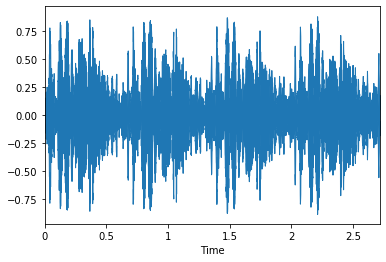

In [29]:
import librosa.display

librosa.display.waveplot(signals.numpy().flatten(),sr=sr)
plt.show()

In [31]:
import matplotlib.pyplot as plt
plt.plot(waveform.audio.flatten()[1024*2:1024*5])

AttributeError: ignored

In [32]:
# Compute a [batch_size, ?, 128] tensor of fixed length, overlapping windows
# where each window overlaps the previous by 75% (frame_length - frame_step
# samples of overlap).

frames = tf.signal.frame(signals, frame_length=128, frame_step=32)
print(frames.numpy().shape)

(1, 1869, 128)


In [33]:
# `magnitude_spectrograms` is a [batch_size, ?, 129] tensor of spectrograms. We
# would like to produce overlapping fixed-size spectrogram patches; for example,
# for use in a situation where a fixed size input is needed.

magnitude_spectrograms = tf.abs(tf.signal.stft(
    signals, frame_length=256, frame_step=64, fft_length=256))

print(magnitude_spectrograms.numpy().shape)

(1, 933, 129)


In [34]:
# `spectrogram_patches` is a [batch_size, ?, 64, 129] tensor containing a
# variable number of [64, 129] spectrogram patches per batch item.

spectrogram_patches = tf.signal.frame(
    magnitude_spectrograms, frame_length=64, frame_step=16, axis=1)

print(spectrogram_patches.numpy().shape)

(1, 55, 64, 129)


## Reconstructing framed sequences and applying a tapering window

In [35]:
# Reconstructs `signals` from `frames` produced in the above example. However,
# the magnitude of `reconstructed_signals` will be greater than `signals`.
reconstructed_signals = tf.signal.overlap_and_add(frames, frame_step=32)
print(reconstructed_signals.numpy().shape)

(1, 59904)


In [36]:
frame_length = 128
frame_step = 32
windowed_frames = frames * tf.signal.hann_window(frame_length)
print(windowed_frames.get_shape())

(1, 1869, 128)


In [37]:
reconstructed_signals = tf.signal.overlap_and_add(
    windowed_frames, frame_step)
reconstructed_signals.numpy().shape

(1, 59904)

## Computing spectrograms
 [Short-time Fourier Transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) (STFT)

In [38]:
# `stfts` is a complex64 Tensor representing the Short-time Fourier Transform of
# each signal in `signals`. Its shape is [batch_size, ?, fft_unique_bins]
# where fft_unique_bins = fft_length // 2 + 1 = 513.
stfts = tf.signal.stft(signals, frame_length=1024, frame_step=512, fft_length=1024)

print(stfts.numpy().shape)

# array = stfts.numpy().astype(np.float)[0]
# plt.imshow(np.swapaxes(array,0,1))

(1, 116, 513)


In [39]:
# a complex number 
stfts.numpy()[0][0][0]

(3.6408608+0j)

### power_spectrograms

(1, 116, 513)


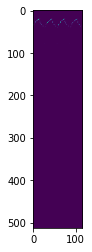

In [42]:
# A power spectrogram is the squared magnitude of the complex-valued STFT.
# A float32 Tensor of shape [batch_size, ?, 513].
power_spectrograms = tf.math.real(stfts * tf.math.conj(stfts))

print(power_spectrograms.numpy().shape)

array = power_spectrograms.numpy().astype(np.float)[0]
plt.imshow(np.swapaxes(array,0,1))

### magnitude_spectrograms

(1, 116, 513)


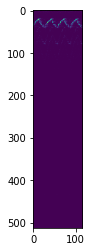

In [43]:
# An energy spectrogram is the magnitude of the complex-valued STFT.
# A float32 Tensor of shape [batch_size, ?, 513].
magnitude_spectrograms = tf.math.abs(stfts)

print(magnitude_spectrograms.numpy().shape)

array = magnitude_spectrograms.numpy().astype(np.float)[0]
plt.imshow(np.swapaxes(array,0,1))

## Logarithmic compression

(1, 116, 513)


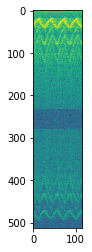

In [44]:
log_offset = 1e-6
log_magnitude_spectrograms = tf.math.log(magnitude_spectrograms + log_offset)
print(log_magnitude_spectrograms.numpy().shape)

array = log_magnitude_spectrograms.numpy().astype(np.float)[0]
plt.imshow(np.swapaxes(array,0,1))

## Computing log-mel spectrograms
When working with spectral representations of audio, the [mel scale](https://en.wikipedia.org/wiki/Mel_scale) is a common reweighting of the frequency dimension, which results in a lower-dimensional and more perceptually-relevant representation of the audio.

Number Spectrogram bins: 513
(1, 116, 64)


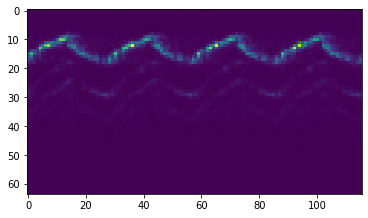

In [51]:
# Warp the linear-scale, magnitude spectrograms into the mel-scale.

num_spectrogram_bins = magnitude_spectrograms.shape[-1]
print('Number spectrogram bins: ' + str(num_spectrogram_bins))

lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 8000, 64

linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz,
    upper_edge_hertz)

mel_spectrograms = tf.tensordot(
    magnitude_spectrograms, linear_to_mel_weight_matrix, 1)

print(mel_spectrograms.numpy().shape)

array = mel_spectrograms.numpy().astype(np.float)[0]
plt.imshow(np.swapaxes(array,0,1))

In [52]:
mel_spectrograms.set_shape(magnitude_spectrograms.shape[:-1].concatenate(
  linear_to_mel_weight_matrix.shape[-1:]))
mel_spectrograms.numpy().shape

(1, 116, 64)

If desired, compress the mel spectrogram magnitudes. For example, you may use logarithmic compression (as discussed in the previous section).

(1, 116, 64)


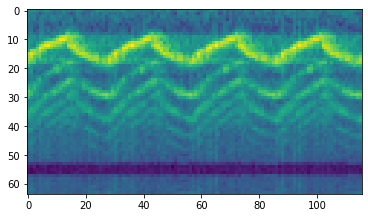

In [54]:
log_offset = 1e-6
log_mel_spectrograms = tf.math.log(mel_spectrograms + log_offset)

print(log_mel_spectrograms.numpy().shape)
array = log_mel_spectrograms.numpy()[0]
plt.imshow(np.swapaxes(array,0,1))

## Computing Mel-Frequency Cepstral Coefficients (MFCCs)

(1, 116, 30)


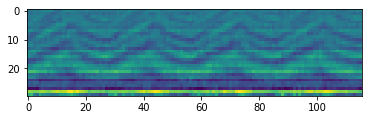

In [55]:
num_mfccs = 30
# Keep the first `num_mfccs` MFCCs.
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
    log_mel_spectrograms)[..., :num_mfccs]
print(mfccs.numpy().shape)
array = mfccs.numpy()[0]
plt.imshow(np.swapaxes(array,0,1)[::-1,:])

```signals->stfts->magnitude_spectrograms->mel_spectrograms->log_mel_spectrograms->mfccs```

In [0]:

def get_mfccs(audio_file=None, signals=None, 
sample_rate = 44100, num_mfccs = 13, 
frame_length=1024, frame_step=512, 
fft_length=1024, fmax=8000, fmin=80):
    """Compute the MFCCs for audio file
    
    Keyword Arguments:
        audio_file {str} -- audio wav file path (default: {None})
        signals {tensor} -- input signals as tensor or np.array in float32 type (default: {None})
        sample_rate {int} -- sampling rate (default: {44100})
        num_mfccs {int} -- number of mfccs to keep (default: {13})
        frame_length {int} -- frame length to compute STFT (default: {1024})
        frame_step {int} -- frame step to compute STFT (default: {512})
        fft_length {int} -- FFT length to compute STFT (default: {1024})
        fmax {int} -- Top edge of the highest frequency band (default: {8000})
        fmin {int} -- Lower bound on the frequencies to be included in the mel spectrum (default: {80})
    
    Returns:
        Tensor -- mfccs as tf.Tensor
    """

    
    if signals is None and audio_file is not None:
      audio_binary = tf.io.read_file(audio_file, name=None)
      waveform = tf.audio.decode_wav(
          audio_binary,
          desired_channels=-1,
          desired_samples=-1,
          name=None)
      
      signals = tf.reshape(waveform.audio, [1, -1])


    # Step 1 : signals->stfts
    # `stfts` is a complex64 Tensor representing the Short-time Fourier Transform of
    # each signal in `signals`. Its shape is [batch_size, ?, fft_unique_bins]
    # where fft_unique_bins = fft_length // 2 + 1 = 513.
    stfts = tf.signal.stft(signals, frame_length=frame_length, frame_step=frame_step,
                                   fft_length=fft_length)
    # Step2 : stfts->magnitude_spectrograms
    # An energy spectrogram is the magnitude of the complex-valued STFT.
    # A float32 Tensor of shape [batch_size, ?, 513].
    magnitude_spectrograms = tf.math.abs(stfts)

    # Step 3 : magnitude_spectrograms->mel_spectrograms
    # Warp the linear-scale, magnitude spectrograms into the mel-scale.
    num_spectrogram_bins = magnitude_spectrograms.shape[-1]

    num_mel_bins = 64

    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, fmin,
        fmax)

    mel_spectrograms = tf.tensordot(
        magnitude_spectrograms, linear_to_mel_weight_matrix, 1)

    # Step 4 : mel_spectrograms->log_mel_spectrograms
    log_offset = 1e-6
    log_mel_spectrograms = tf.math.log(mel_spectrograms + log_offset)

    # Step 5 : log_mel_spectrograms->mfccs
    # Keep the first `num_mfccs` MFCCs.
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(
        log_mel_spectrograms)[..., :num_mfccs]
    
    return mfccs

mfccs shape (1, 116, 30)


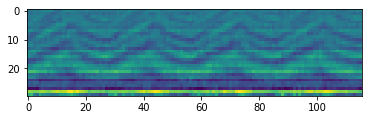

In [58]:
mfccs = get_mfccs(signals = signals, sample_rate=sr, num_mfccs = 30)

print("mfccs shape", mfccs.numpy().shape)
array = mfccs.numpy()[0]
plt.imshow(np.swapaxes(array,0,1)[::-1,:])